# COVID Global Forecast: SIR model + ML regressions

In the context of the global COVID-19 pandemic, Kaggle has launched several challenges in order to provide useful insights that may answer some of the open scientific questions about the virus. This is the case of the [COVID19 Global Forecasting](https://www.kaggle.com/c/covid19-global-forecasting-week-1), in which participants are encouraged to fit worldwide data in order to predict the pandemic evolution, hopefully helping to determine which factors impact the transmission behavior of COVID-19.

**TABLE OF CONTENTS**

1. [Exploratory data analysis (EDA)](#section1)

    1.1. [COVID-19 global tendency excluding China](#section11)
    
    1.2. [COVID-19 tendency in China](#section12)
    
    1.3. [Italy, Spain, UK and US](#section13)
    
2. [SIR model](#section2)

    2.1. [Implementing the SIR model](#section21)
    
3. [Data enrichment](#section3)

    3.1. [Join data, filter dates and clean missings](#section31)
    
    3.2. [Compute lags and trends](#section32)
    
    3.3. [Add country details](#section33)
    
4. [Predictions with machine learning](#section4)

    4.1. [Linear Regression for one country](#section41)   
    
    4.2. [Logistic regression with lags](#section42)

**Disclaimer 1**: this notebook is still under construction.

**Disclaimer 2**: the training dataset is being updated on a daily basis, in order to include the most recent cases. I'll try to keep the notebook updated in order to prevent data leaking and other potential problems.

In [1]:
!pip install lightgbm
!pip install xgboost
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
import time
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# ML libraries
import lightgbm as lgb
import xgboost as xgb

from xgboost import plot_importance, plot_tree
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn import linear_model
from sklearn.metrics import mean_squared_error

You should consider upgrading via the '/opt/anaconda3/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/opt/anaconda3/bin/python -m pip install --upgrade pip' command.


# 1. Exploratory data analysis (EDA) <a id="section1"></a>

First of all, let's take a look on the data structure:

The dataset covers 163 countries and almost 2 full months from 2020, which is enough data to get some clues about the pandemic. Let's see a few plots of the worldwide tendency to see if we can extract some insights:

**Observations**: The global curve shows a rich fine structure, but these numbers are strongly affected by the vector zero country, China. Given that COVID-19 started there, during the initial expansion of the virus there was no reliable information about the real infected cases. In fact,  the criteria to consider infection cases was modified around 2020-02-11, which strongly perturbed the curve as you can see from the figure. 

## 1.1. COVID-19 global tendency excluding China and in China <a id="section11"></a>

Since details of the initial breakthrough strongly interfere with the results, it's recomended to analyze China independently. Let's first see the results without China: 

(17892, 8)
   Id Province/State Country/Region   Lat  Long        Date  ConfirmedCases  \
0   1            NaN    Afghanistan  33.0  65.0  2020-01-22             0.0   
1   2            NaN    Afghanistan  33.0  65.0  2020-01-23             0.0   
2   3            NaN    Afghanistan  33.0  65.0  2020-01-24             0.0   
3   4            NaN    Afghanistan  33.0  65.0  2020-01-25             0.0   
4   5            NaN    Afghanistan  33.0  65.0  2020-01-26             0.0   

   Fatalities  
0         0.0  
1         0.0  
2         0.0  
3         0.0  
4         0.0  


Text(0.5, 0, 'Date')

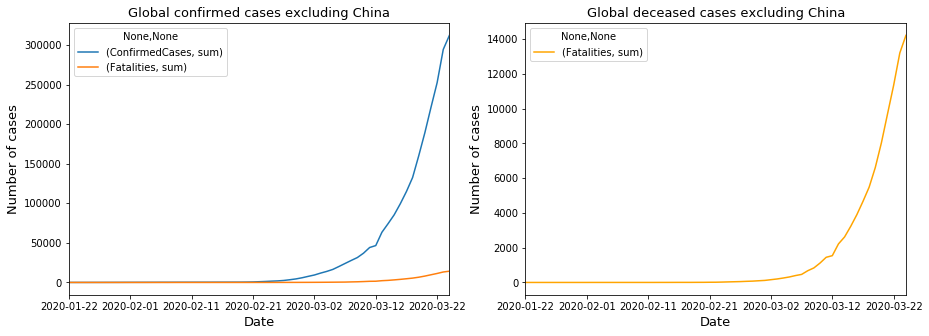

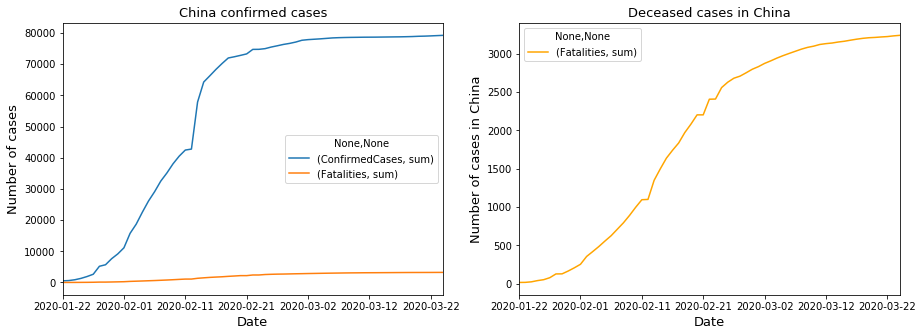

In [2]:
test = pd.read_csv("../input/test.csv")
train = pd.read_csv("../input/train.csv")

submission = pd.read_csv("../input/submission.csv")
print(train.shape)
print(train.head(5))

pop_italy = 60486683.
pop_spain = 46749696.
pop_UK = 67784927.
pop_US = 331002651.
confirmed_total_date_noChina = train[train['Country/Region']!='China'].groupby(['Date']).agg({'ConfirmedCases':['sum']})
fatalities_total_date_noChina = train[train['Country/Region']!='China'].groupby(['Date']).agg({'Fatalities':['sum']})
total_date_noChina = confirmed_total_date_noChina.join(fatalities_total_date_noChina)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))

total_date_noChina.plot(ax=ax1)
ax1.set_title("Global confirmed cases excluding China", size=13)
ax1.set_ylabel("Number of cases", size=13)
ax1.set_xlabel("Date", size=13)

fatalities_total_date_noChina.plot(ax=ax2, color='orange')
ax2.set_title("Global deceased cases excluding China", size=13)
ax2.set_ylabel("Number of cases", size=13)
ax2.set_xlabel("Date", size=13)


confirmed_total_date_China = train[train['Country/Region']=='China'].groupby(['Date']).agg({'ConfirmedCases':['sum']})
fatalities_total_date_China = train[train['Country/Region']=='China'].groupby(['Date']).agg({'Fatalities':['sum']})
total_date_China = confirmed_total_date_China.join(fatalities_total_date_China)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
total_date_China.plot(ax=ax1)
ax1.set_title("China confirmed cases", size=13)
ax1.set_ylabel("Number of cases", size=13)
ax1.set_xlabel("Date", size=13)

fatalities_total_date_China.plot(ax=ax2, color='orange')
ax2.set_title("Deceased cases in China", size=13)
ax2.set_ylabel("Number of cases in China", size=13)
ax2.set_xlabel("Date", size=13)

**Observations**: In this case the general behavior looks cleaner, and in fact the curve resembles a typical epidemiology model like [SIR](http://mat.uab.cat/matmat/PDFv2013/v2013n03.pdf). SIR models present a large increasing in the number of infections that, once it reaches the maximum of the contagion, decreases with a lower slope. For comparison, a SIR simulation from section [2. SIR model]

**Observations**:

* **Smoothness**. Both plots are less smooth than theoretical simulations or the curve from the rest of the world cumulative
* **Infected criteria**. The moment in which the criteria to consider an infected case was changed is direclty spotted
* **Irregularities**. There are some iregularities. I should check the literature in depth to look for evidences, but the reasons may be that both the resources spent to monitor the epidemy and the security measures to stop ot have been changing over time
* **Plateaux**. It looks like the curve has reached a plateaux, which would imply that China is on their maximum of contagion 

## 1.3. Tendency in Italy, Spain, UK and US <a id="section13"></a>

Both Italy and Spain are experiencing the larger increase in COVID-19 positives in Europe. At the same time, UK is a unique case given that it's one of the most important countries in Europe but recently has left the European Union, which has create an effective barrier to human mobility from other countries. 

Text(0, 0.5, 'Confirmed infection cases')

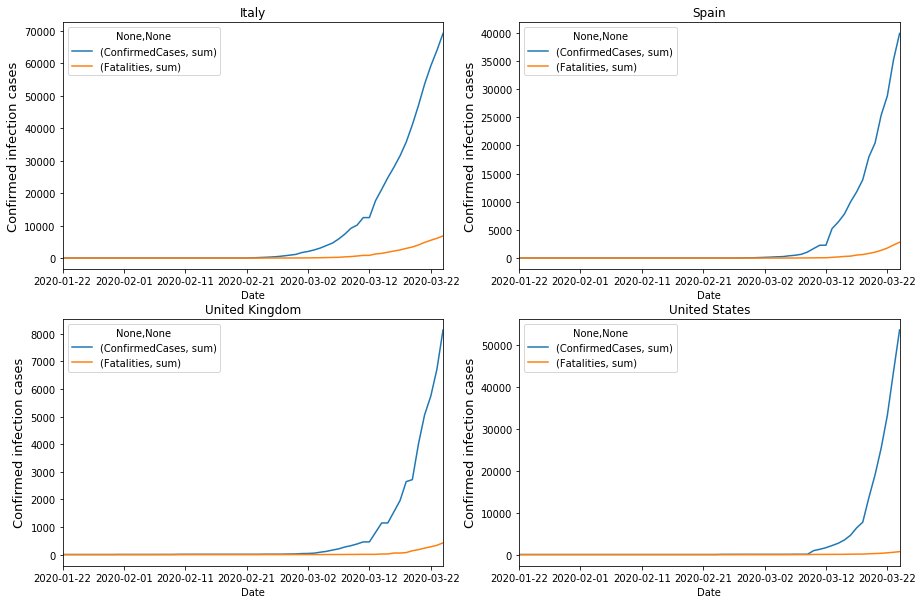

In [3]:

confirmed_total_date_Italy = train[train['Country/Region']=='Italy'].groupby(['Date']).agg({'ConfirmedCases':['sum']})
fatalities_total_date_Italy = train[train['Country/Region']=='Italy'].groupby(['Date']).agg({'Fatalities':['sum']})
total_date_Italy = confirmed_total_date_Italy.join(fatalities_total_date_Italy)

confirmed_total_date_Spain = train[train['Country/Region']=='Spain'].groupby(['Date']).agg({'ConfirmedCases':['sum']})
fatalities_total_date_Spain = train[train['Country/Region']=='Spain'].groupby(['Date']).agg({'Fatalities':['sum']})
total_date_Spain = confirmed_total_date_Spain.join(fatalities_total_date_Spain)


confirmed_total_date_UK = train[train['Country/Region']=='United Kingdom'].groupby(['Date']).agg({'ConfirmedCases':['sum']})
fatalities_total_date_UK = train[train['Country/Region']=='United Kingdom'].groupby(['Date']).agg({'Fatalities':['sum']})
total_date_UK = confirmed_total_date_UK.join(fatalities_total_date_UK)

confirmed_total_date_US = train[train['Country/Region']=='US'].groupby(['Date']).agg({'ConfirmedCases':['sum']})
fatalities_total_date_US  = train[train['Country/Region']=='US'].groupby(['Date']).agg({'Fatalities':['sum']})
total_date_US = confirmed_total_date_US.join(fatalities_total_date_US)


plt.figure(figsize=(15,10))
plt.subplot(2, 2, 1)
total_date_Italy.plot(ax=plt.gca(), title='Italy')
plt.ylabel("Confirmed infection cases", size=13)


plt.subplot(2, 2, 2)
total_date_Spain.plot(ax=plt.gca(), title='Spain')
plt.ylabel("Confirmed infection cases", size=13)

plt.subplot(2, 2, 3)
total_date_UK.plot(ax=plt.gca(), title='United Kingdom')
plt.ylabel("Confirmed infection cases", size=13)

plt.subplot(2, 2, 4)
total_date_US.plot(ax=plt.gca(), title='United States')
plt.ylabel("Confirmed infection cases", size=13)


As a fraction of the total population of each country:

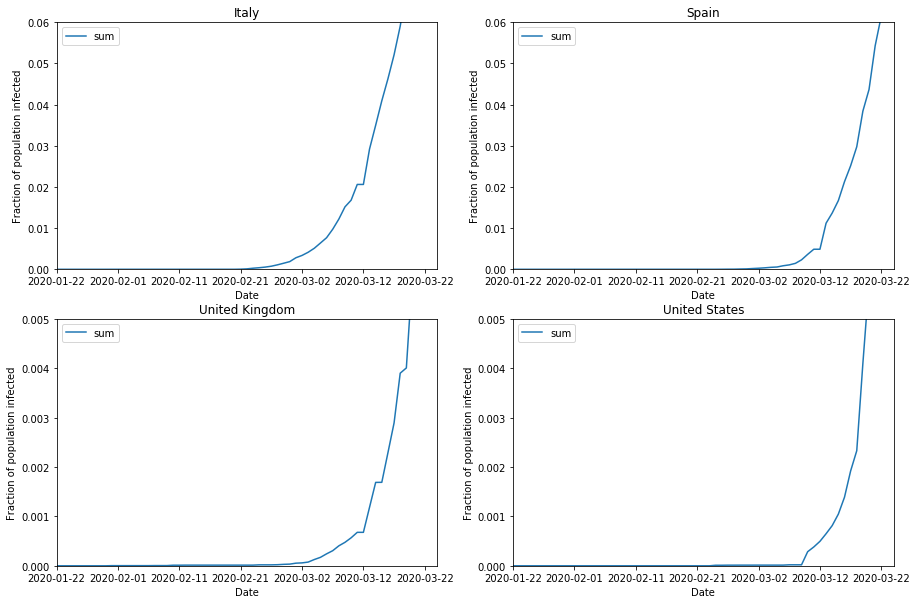

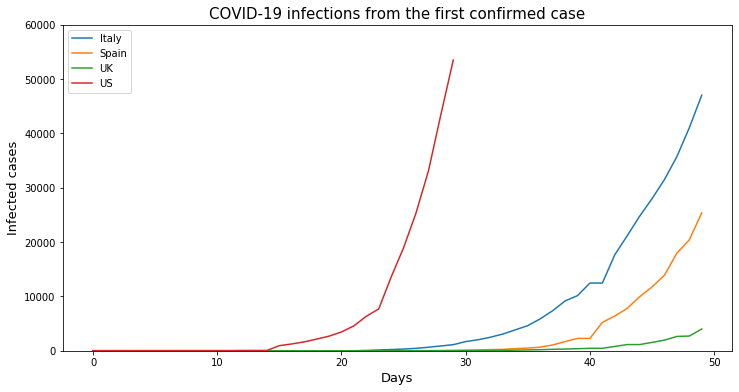

In [4]:
total_date_Italy.ConfirmedCases = total_date_Italy.ConfirmedCases/pop_italy*100.
total_date_Italy.Fatalities = total_date_Italy.ConfirmedCases/pop_italy*100.
total_date_Spain.ConfirmedCases = total_date_Spain.ConfirmedCases/pop_spain*100.
total_date_Spain.Fatalities = total_date_Spain.ConfirmedCases/pop_spain*100.
total_date_UK.ConfirmedCases = total_date_UK.ConfirmedCases/pop_UK*100.
total_date_UK.Fatalities = total_date_UK.ConfirmedCases/pop_UK*100.
total_date_US.ConfirmedCases = total_date_US.ConfirmedCases/pop_US*100.
total_date_US.Fatalities = total_date_US.ConfirmedCases/pop_US*100.


plt.figure(figsize=(15,10))
plt.subplot(2, 2, 1)
total_date_Italy.ConfirmedCases.plot(ax=plt.gca(), title='Italy')
plt.ylabel("Fraction of population infected")
plt.ylim(0, 0.06)

plt.subplot(2, 2, 2)
total_date_Spain.ConfirmedCases.plot(ax=plt.gca(), title='Spain')
plt.ylabel("Fraction of population infected")
plt.ylim(0, 0.06)

plt.subplot(2, 2, 3)
total_date_UK.ConfirmedCases.plot(ax=plt.gca(), title='United Kingdom')
plt.ylabel("Fraction of population infected")
plt.ylim(0, 0.005)

plt.subplot(2, 2, 4)
total_date_US.ConfirmedCases.plot(ax=plt.gca(), title='United States')
plt.ylabel("Fraction of population infected")
plt.ylim(0, 0.005)


confirmed_total_date_Italy = train[(train['Country/Region']=='Italy') & train['ConfirmedCases']!=0].groupby(['Date']).agg({'ConfirmedCases':['sum']})
fatalities_total_date_Italy = train[(train['Country/Region']=='Italy') & train['ConfirmedCases']!=0].groupby(['Date']).agg({'Fatalities':['sum']})
total_date_Italy = confirmed_total_date_Italy.join(fatalities_total_date_Italy)

confirmed_total_date_Spain = train[(train['Country/Region']=='Spain') & (train['ConfirmedCases']!=0)].groupby(['Date']).agg({'ConfirmedCases':['sum']})
fatalities_total_date_Spain = train[(train['Country/Region']=='Spain') & (train['ConfirmedCases']!=0)].groupby(['Date']).agg({'Fatalities':['sum']})
total_date_Spain = confirmed_total_date_Spain.join(fatalities_total_date_Spain)

confirmed_total_date_UK = train[(train['Country/Region']=='United Kingdom') & (train['ConfirmedCases']!=0)].groupby(['Date']).agg({'ConfirmedCases':['sum']})
fatalities_total_date_UK = train[(train['Country/Region']=='United Kingdom') & (train['ConfirmedCases']!=0)].groupby(['Date']).agg({'Fatalities':['sum']})
total_date_UK = confirmed_total_date_UK.join(fatalities_total_date_UK)


confirmed_total_date_US = train[(train['Country/Region']=='US') & (train['ConfirmedCases']!=0)].groupby(['Date']).agg({'ConfirmedCases':['sum']})
fatalities_total_date_US = train[(train['Country/Region']=='US') & (train['ConfirmedCases']!=0)].groupby(['Date']).agg({'Fatalities':['sum']})
total_date_US = confirmed_total_date_US.join(fatalities_total_date_US)



italy = [i for i in total_date_Italy.ConfirmedCases['sum'].values]
italy_30 = italy[0:50] 
spain = [i for i in total_date_Spain.ConfirmedCases['sum'].values]
spain_30 = spain[0:50] 
UK = [i for i in total_date_UK.ConfirmedCases['sum'].values]
UK_30 = UK[0:50] 
US = [i for i in total_date_US.ConfirmedCases['sum'].values]
US_30 = US[0:50] 

# Plots
plt.figure(figsize=(12,6))
plt.plot(italy_30)
plt.plot(spain_30)
plt.plot(UK_30)
plt.plot(US_30)
plt.legend(["Italy", "Spain", "UK", "US"], loc='upper left')
plt.title("COVID-19 infections from the first confirmed case", size=15)
plt.xlabel("Days", size=13)
plt.ylabel("Infected cases", size=13)
plt.ylim(0, 60000)
plt.show()


**Observations**:
* **Italy**. With more than 35.000 confirmed cases, Italy shows one of the most alarming scenarios of COVID-19. The infections curve is very steep, and the percentage of population infected is near the 0.1%
* **Spain**. Spain is the second country from the EU with more confirmed COVID-19 cases, slightly below 15.000 cases. Around 0.03% of the population has currently (2020-03-19) contracted the virus
* **United Kingdom**. Despite not being very far from them, the UK shows less cases. There are several theories for this; @codingdon pointed out in the direction of a lower number of COVID-19 tests, and I think that maybe the Brexit process had an impact into international travels that delayed the arrival of the COVID-19 (baed on [this](https://www.ons.gov.uk/peoplepopulationandcommunity/leisureandtourism/articles/traveltrends/2018). Anyway, these are just theories and we can't take anything for granted. Only a 0.004% of UK citizens have been reported by COVID-19 infection
* **United States**. Despite the virus spreaded in the US at last, the speed curve of infection is the steep. 

# 2. SIR model <a id="section2"></a>

We have seen some general behavior of the virus in agregated data, for the country where the coronavirus was originated and for four other interesting countries. There's a lot of information to be extracted from this data; for example, we haven't analyzed the effects of long/lat of countries. However, since our main purpose is to develop a predective model in order to understand the key factors that impact the COVID-19 transmission, I'll move on to one of the most famous epidemiologic models: SIR. 

SIR is a simple model that considers a population that belongs to one of the following states:
1. **Susceptible (S)**. The individual hasn't contracted the disease, but she can be infected due to transmisison from infected people
2. **Infected (I)**. This person has contracted the disease
3. **Recovered/Deceased (R)**. The disease may lead to one of two destinies: either the person survives, hence developing inmunity to the disease, or the person is deceased. 

<img src="https://www.lewuathe.com/assets/img/posts/2020-03-11-covid-19-dynamics-with-sir-model/sir.png" width="500px">
Image by Kai Sasaki from [lewuathe.com](https://www.lewuathe.com/covid-19-dynamics-with-sir-model.html)

There are many versions of this model, considering birth and death (SIRD with demography), with intermediate states, etc. However, since we are in the early stages of the COVID-19 expansion and our interest is focused in the short term, we will consider that people develops immunity (in the long term, immunity may be lost and the COVID-19 may come back within a certain seasonality like the common flu) and there is no transition from recovered to the remaining two states. With this, the differential equations that govern the system are:

$$ {dS \over dt} = - {\beta S I \over N} $$

$$ {dI \over dt} = {\beta S I \over N} - \gamma I$$

$$ {dR \over dt} = \gamma I$$

Where $\beta$ is the contagion rate of the pathogen and $\gamma$ is the recovery rate.

## 2.1. Implementing the SIR model <a id="section21"></a>

SIR model can be implemented in many ways: from the differential equations governing the system, within a mean field approximation or running the dynamics in a social network (graph). For the sake of simplicity, I'vem chosen the first option, and we will simply run a numerical method (Runge-Kutta) to solve the differential equations system. 

The functions governing the dif.eqs. are:

In [5]:
# Susceptible equation
def fa(N, a, b, beta):
    fa = -beta*a*b
    return fa

# Infected equation
def fb(N, a, b, beta, gamma):
    fb = beta*a*b - gamma*b
    return fb

# Recovered/deceased equation
def fc(N, b, gamma):
    fc = gamma*b
    return fc
# In order to solve the differential equations system, we develop a 4rth order Runge-Kutta method:
# Runge-Kutta method of 4rth order for 3 dimensions (susceptible a, infected b and recovered r)
def rK4(N, a, b, c, fa, fb, fc, beta, gamma, hs):
    a1 = fa(N, a, b, beta)*hs
    b1 = fb(N, a, b, beta, gamma)*hs
    c1 = fc(N, b, gamma)*hs
    ak = a + a1*0.5
    bk = b + b1*0.5
    ck = c + c1*0.5
    a2 = fa(N, ak, bk, beta)*hs
    b2 = fb(N, ak, bk, beta, gamma)*hs
    c2 = fc(N, bk, gamma)*hs
    ak = a + a2*0.5
    bk = b + b2*0.5
    ck = c + c2*0.5
    a3 = fa(N, ak, bk, beta)*hs
    b3 = fb(N, ak, bk, beta, gamma)*hs
    c3 = fc(N, bk, gamma)*hs
    ak = a + a3
    bk = b + b3
    ck = c + c3
    a4 = fa(N, ak, bk, beta)*hs
    b4 = fb(N, ak, bk, beta, gamma)*hs
    c4 = fc(N, bk, gamma)*hs
    a = a + (a1 + 2*(a2 + a3) + a4)/6
    b = b + (b1 + 2*(b2 + b3) + b4)/6
    c = c + (c1 + 2*(c2 + c3) + c4)/6
    return a, b, c

And finally, to obtain the evolution of the disease we simply define the initial conditions and call the rk4 method:

In [6]:
def SIR(N, b0, beta, gamma, hs):
    
    """
    N = total number of population
    beta = transition rate S->I
    gamma = transition rate I->R
    k =  denotes the constant degree distribution of the network (average value for networks in which 
    the probability of finding a node with a different connectivity decays exponentially fast
    hs = jump step of the numerical integration
    """
    
    # Initial condition
    a = float(N-1)/N -b0
    b = float(1)/N +b0
    c = 0.

    sus, inf, rec= [],[],[]
    for i in range(10000): # Run for a certain number of time-steps
        sus.append(a)
        inf.append(b)
        rec.append(c)
        a,b,c = rK4(N, a, b, c, fa, fb, fc, beta, gamma, hs)

    return sus, inf, rec





Results obtained for N=world population, only one initial infected case, $\beta=0.3$, $\gamma=0.5$ and a leap pass $h_s = 0.1$ are shown below:

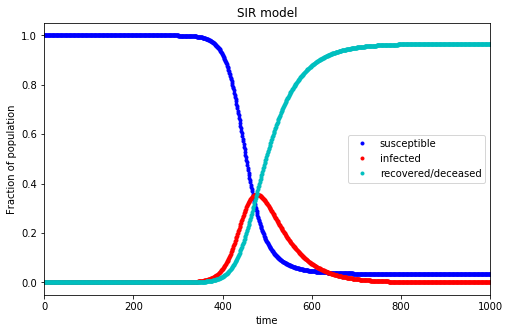

In [7]:
# Parameters of the model
N = 7800*(10**6)
b0 = 0
beta = 0.7
gamma = 0.2
hs = 0.1

sus, inf, rec = SIR(N, b0, beta, gamma, hs)

f = plt.figure(figsize=(8,5)) 
plt.plot(sus, 'b.', label='susceptible');
plt.plot(inf, 'r.', label='infected');
plt.plot(rec, 'c.', label='recovered/deceased');
plt.title("SIR model")
plt.xlabel("time", fontsize=10);
plt.ylabel("Fraction of population", fontsize=10);
plt.legend(loc='best')
plt.xlim(0,1000)
plt.savefig('SIR_example.png')
plt.show()

**Observations**: 
* The number of infected cases increases for a certain time period, and then eventually decreases given that individuals recover/decease from the disease
* The susceptible fraction of population decreases as the virus is transmited, to eventually drop to the absorbent state 0
* The oposite happens for the recovered/deceased case

Notice that different initial conditions and parameter values will lead to other scenarios, feel free to play with these numbers to study the system.

# 3. Data enrichment <a id="section3"></a>

Analyzing SIR simulations was meant to understand a model that approximately resembles the transmission mechanism of many virus, including the COVID-19. However, there are alternative methods that may prove being equally useful both to predict and to understand the pandemic evolution. Many of these methods rely on having rich data to extract conclusions and allow algorithms to extrapolate patterns in data, and that is exactly what we are going to do. 

Main workflow of this section:
1. Join data, filter dates and clean missings
2. Compute lags and trends
3. Add country details

**Disclaimer**: this data enrichment is not mandatory and we could end up not using all of the new features in our models. However I consider it a didactical step that will surely add some value, for example in an in-depth exploratory analysis.

## 3.1. Join data, filter dates and clean missings(Data Preprocessing) <a id="section31"></a>

First of all, we perform some pre-processing prepare the dataset, consisting on:

* **Join data**. Join train/test to facilitate data transformations
* **Filter dates**. According to the challenge conditions, remove ConfirmedCases and Fatalities post 2020-03-12. Create additional date columns
* **Missings**. Analyze and fix missing values

In [8]:
# Merge train and test, exclude overlap
dates_overlap = ['2020-03-12','2020-03-13','2020-03-14','2020-03-15','2020-03-16','2020-03-17','2020-03-18',
                 '2020-03-19','2020-03-20','2020-03-21','2020-03-22','2020-03-23', '2020-03-24']
train2 = train.loc[~train['Date'].isin(dates_overlap)]
all_data = pd.concat([train2, test], axis = 0, sort=False)
# Double check that there are no informed ConfirmedCases and Fatalities after 2020-03-11
all_data.loc[all_data['Date'] >= '2020-03-12', 'ConfirmedCases'] = np.nan
all_data.loc[all_data['Date'] >= '2020-03-12', 'Fatalities'] = np.nan
all_data['Date'] = pd.to_datetime(all_data['Date'])

# Create date columns
le = preprocessing.LabelEncoder()
all_data['Day_num'] = le.fit_transform(all_data.Date)
all_data['Day'] = all_data['Date'].dt.day
all_data['Month'] = all_data['Date'].dt.month
all_data['Year'] = all_data['Date'].dt.year

# Fill null values given that we merged train-test datasets
all_data['Province/State'].fillna("None", inplace=True)
all_data['ConfirmedCases'].fillna(0, inplace=True)
all_data['Fatalities'].fillna(0, inplace=True)
all_data['Id'].fillna(-1, inplace=True)
all_data['ForecastId'].fillna(-1, inplace=True)

# Aruba has no Lat nor Long. Inform it manually
all_data.loc[all_data['Lat'].isna()==True, 'Lat'] = 12.510052
all_data.loc[all_data['Long'].isna()==True, 'Long'] = -70.009354


**Observations**: 
* "ConfirmedCases" and "Fatalities" are now only informed for dates previous to 2020-03-12
* The dataset includes all countries and dates, which is required for the lag/trend step
* Missing values for "ConfirmedCases" and "Fatalities" have been replaced by 0, which may be dangerous if we do not remember it at the end of the process. However, since we will train only on dates previous to 2020-03-12, this won't impact our prediction algorithm
* A new column "Day" has been created, as a day counter starting from the first date


## 3.2. Compute lags and trends <a id="section32"></a>

Enriching a dataset is key to obtain good results. In this case we will apply 2 different transformations:

**Lag**. Lags are a way to compute the previous value of a column, so that the lag 1 for ConfirmedCases would inform the this column from the previous day. The lag 3 of a feature X is simply:
$$X_{lag3}(t) = X(t-3)$$


**Trend**. Transformig a column into its trend gives the natural tendency of this column, which is different from the raw value. The definition of trend I will apply is: 
$$Trend_{X} = {X(t) - X(t-1) \over X(t-1)}$$

The backlog of lags I'll apply is 14 days, while for trends is 7 days.  For ConfirmedCases and Fatalities:

In [9]:
def calculate_trend(df, lag_list, column):
    for lag in lag_list:
        trend_column_lag = "Trend_" + column + "_" + str(lag)
        df[trend_column_lag] = (df[column]-df[column].shift(lag, fill_value=-999))/df[column].shift(lag, fill_value=0)
    return df


def calculate_lag(df, lag_list, column):
    for lag in lag_list:
        column_lag = column + "_" + str(lag)
        df[column_lag] = df[column].shift(lag, fill_value=0)
    return df


ts = time.time()
all_data = calculate_lag(all_data, range(1,7), 'ConfirmedCases')
all_data = calculate_lag(all_data, range(1,7), 'Fatalities')
all_data = calculate_trend(all_data, range(1,7), 'ConfirmedCases')
all_data = calculate_trend(all_data, range(1,7), 'Fatalities')
all_data.replace([np.inf, -np.inf], 0, inplace=True)
all_data.fillna(0, inplace=True)
print("Time spent: ", time.time()-ts)


Time spent:  0.21341896057128906


As you see, the process is really fast. An example of some of the lag/trend columns for Spain:

## 3.3. Add country details <a id="section33"></a>

Variables like the total population of a country, the average age of citizens or the fraction of peoople living in cities may strongly impact on the COVID-19 transmission behavior. Hence, it's important to consider these factors. I'm using [Tanu's dataset](https://www.kaggle.com/tanuprabhu/population-by-country-2020) based on Web Scrapping for this purpose.

In [10]:
# Load countries data file
world_population = pd.read_csv("../input/population_by_country_2020.csv")

# Select desired columns and rename some of them
world_population = world_population[['Country (or dependency)', 'Population (2020)', 'Density (P/Km²)', 'Land Area (Km²)', 'Med. Age', 'Urban Pop %']]
world_population.columns = ['Country (or dependency)', 'Population (2020)', 'Density', 'Land Area', 'Med Age', 'Urban Pop']

# Replace United States by US
world_population.loc[world_population['Country (or dependency)']=='United States', 'Country (or dependency)'] = 'US'

# Remove the % character from Urban Pop values
world_population['Urban Pop'] = world_population['Urban Pop'].str.rstrip('%')

# Replace Urban Pop and Med Age "N.A" by their respective modes, then transform to int
world_population.loc[world_population['Urban Pop']=='N.A.', 'Urban Pop'] = int(world_population.loc[world_population['Urban Pop']!='N.A.', 'Urban Pop'].mode()[0])
world_population['Urban Pop'] = world_population['Urban Pop'].astype('int16')
world_population.loc[world_population['Med Age']=='N.A.', 'Med Age'] = int(world_population.loc[world_population['Med Age']!='N.A.', 'Med Age'].mode()[0])
world_population['Med Age'] = world_population['Med Age'].astype('int16')



# Now join the dataset to our previous DataFrame and clean missings (not match in left join)- label encode cities

all_data = all_data.merge(world_population, left_on='Country/Region', right_on='Country (or dependency)', how='left')
all_data[['Population (2020)', 'Density', 'Land Area', 'Med Age', 'Urban Pop']] = all_data[['Population (2020)', 'Density', 'Land Area', 'Med Age', 'Urban Pop']].fillna(0)


# Label encode countries and provinces. Save dictionary for exploration purposes
all_data.drop('Country (or dependency)', inplace=True, axis=1)
all_data['Country/Region'] = le.fit_transform(all_data['Country/Region'])
number_c = all_data['Country/Region']
countries = le.inverse_transform(all_data['Country/Region'])
country_dict = dict(zip(countries, number_c)) 
all_data['Province/State'] = le.fit_transform(all_data['Province/State'])
number_p = all_data['Province/State']
province = le.inverse_transform(all_data['Province/State'])
province_dict = dict(zip(province, number_p)) 



# 4. Predictions with machine learning <a id="section4"></a>

Our obective in this section consists on  predicting the evolution of the expansion from a data-centric perspective, like any other regression problem. To do so, remember that the challenge specifies that submissions on the public LB shouldn only contain data previous to 2020-03-12.

Models to apply:
1. Linear Regression for one country
2. Linear Regression for all countries (method 1)
3. Linear Regression for all countries (method 2)

## 4.1. Linear Regression for one country <a id="section41"></a>

Since we are interested into predicting the future time evolution of the pandemic, our first approach consists on a simple Linear Regression. However, remind that the evolution is not linear but exponential (only in the beginning of the infection), so that a preliminar log transformation is needed. 

Visual comparison of both cases for Spain and with data from last 10 days informed, starting on March 1st:

As you see, the log transformation results in a fancy straight-like line, which is awesome for Linear Regression. However, let me clarify two important points:

* This "roughly exponential behavior" is only true for the initial infection stages of the pandemic (the initial increasing of infections on the SIR model), but that's exactly the point where most countries are at the moment.

* Why do I only extract the last 10 days of data? For three reasons:
    1. In order to capture exactly the very short term component of the evolution
    2. To prevent the effects of certain variables that have been impacting the transmition speed (quarantine vs free circulation)
    3. To prevent differences on criteria when confirming cases (remember that weird slope on the China plot?)

This first model is very simple, and only elemental features will be considered: Country/Region, date information, Long and Lat. Lags. Engineered columns like lags, trends and country details are not introduced as an input. Finally, the workflow for the Basic Linear Regression model is:
1. **Features**. Select features
2. **Dates**. Filter train data from 2020-03-01 to 2020-03-11
2. **Log transformation**. Apply log transformation to ConfirmedCases and Fatalities
3. **Infinites**. Replace infinites from the logarithm with 0. Given the asymptotic behavior of the logarithm for log(0),this implies that when applying the inverse transformation (exponential) a 1 will be returned instead of a 0. This problem does not impact many countries, but still needs to be tackled sooner or later in order to obtain a clean solution.
4. **Train/test split**. Split into train/valid/test
5. **Prediction**. Linear Regression, training country by country and joining data
6. **Submit**. Submit results in the correct format, and applying exponential to reverse log transformation 

In [11]:
# Filter selected features
data = all_data.copy()
features = ['Id', 'ForecastId', 'Country/Region', 'Province/State', 'ConfirmedCases', 'Fatalities', 
       'Day_num', 'Day', 'Month', 'Year', 'Long', 'Lat']
data = data[features]

# Apply log transformation to all ConfirmedCases and Fatalities columns, except for trends
data[['ConfirmedCases', 'Fatalities']] = data[['ConfirmedCases', 'Fatalities']].astype('float64')
data[['ConfirmedCases', 'Fatalities']] = data[['ConfirmedCases', 'Fatalities']].apply(lambda x: np.log(x))

# Replace infinites
data.replace([np.inf, -np.inf], 0, inplace=True)


# Split data into train/test
def split_data(data):
    
    # Train set
    x_train = data[data.ForecastId == -1].drop(['ConfirmedCases', 'Fatalities'], axis=1)
    y_train_1 = data[data.ForecastId == -1]['ConfirmedCases']
    y_train_2 = data[data.ForecastId == -1]['Fatalities']

    # Test set
    x_test = data[data.ForecastId != -1].drop(['ConfirmedCases', 'Fatalities'], axis=1)

    # Clean Id columns and keep ForecastId as index
    x_train.drop('Id', inplace=True, errors='ignore', axis=1)
    x_train.drop('ForecastId', inplace=True, errors='ignore', axis=1)
    x_test.drop('Id', inplace=True, errors='ignore', axis=1)
    x_test.drop('ForecastId', inplace=True, errors='ignore', axis=1)
    
    return x_train, y_train_1, y_train_2, x_test


# Linear regression model
def lin_reg(X_train, Y_train, X_test):
    # Create linear regression object
    regr = linear_model.LinearRegression()

    # Train the model using the training sets
    regr.fit(X_train, Y_train)

    # Make predictions using the testing set
    y_pred = regr.predict(X_test)
    
    return regr, y_pred


# Submission function
def get_submission(df, target1, target2):
    
    prediction_1 = df[target1]
    prediction_2 = df[target2]

    # Submit predictions
    prediction_1 = [int(item) for item in list(map(round, prediction_1))]
    prediction_2 = [int(item) for item in list(map(round, prediction_2))]
    
    submission = pd.DataFrame({
        "ForecastId": df['ForecastId'].astype('int32'), 
        "ConfirmedCases": prediction_1, 
        "Fatalities": prediction_2
    })
    submission.to_csv('submission.csv', index=False)

Let's try to see results when training with a single country:


Text(0.5, 0.98, 'ConfirmedCases predictions based on Linear Regression for Italy')

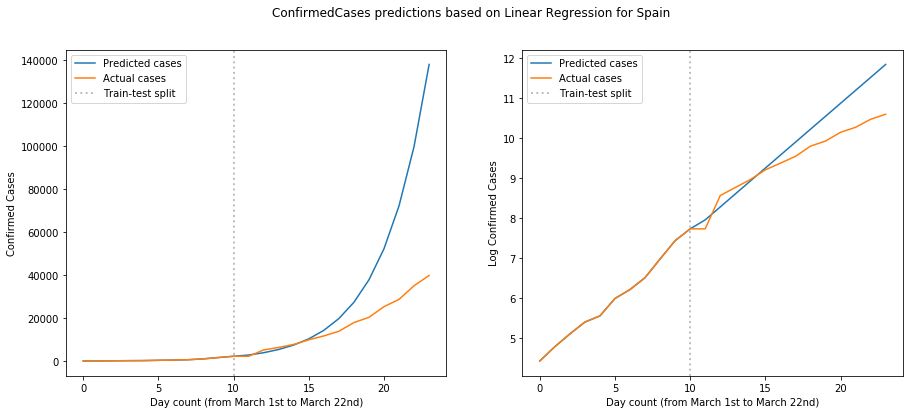

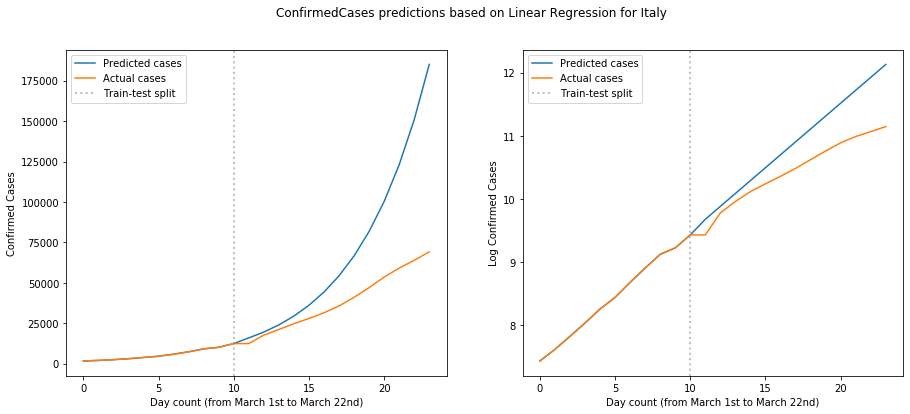

In [12]:
# Select train (real) data from March 1 to March 22nd
dates_list = ['2020-03-01', '2020-03-02', '2020-03-03', '2020-03-04', '2020-03-05', '2020-03-06', '2020-03-07', '2020-03-08', '2020-03-09', 
                 '2020-03-10', '2020-03-11','2020-03-12','2020-03-13','2020-03-14','2020-03-15','2020-03-16','2020-03-17','2020-03-18',
                 '2020-03-19','2020-03-20','2020-03-21','2020-03-22','2020-03-23', '2020-03-24']

# Filter Spain, run the Linear Regression workflow
country_name = "Spain"
day_start = 39
data_country = data[data['Country/Region']==country_dict[country_name]]
data_country = data_country.loc[data_country['Day_num']>=day_start]
X_train, Y_train_1, Y_train_2, X_test = split_data(data_country)
model, pred = lin_reg(X_train, Y_train_1, X_test)

# Create a df with both real cases and predictions (predictions starting on March 12th)
X_train_check = X_train.copy()
X_train_check['Target'] = Y_train_1

X_test_check = X_test.copy()
X_test_check['Target'] = pred

X_final_check = pd.concat([X_train_check, X_test_check])

# Select predictions from March 1st to March 24th
predicted_data = X_final_check.loc[(X_final_check['Day_num'].isin(list(range(day_start, day_start+len(dates_list)))))].Target
real_data = train.loc[(train['Country/Region']==country_name) & (train['Date'].isin(dates_list))]['ConfirmedCases']
dates_list_num = list(range(0,len(dates_list)))

# Plot results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,6))

ax1.plot(dates_list_num, np.exp(predicted_data))
ax1.plot(dates_list_num, real_data)
ax1.axvline(10, linewidth=2, ls = ':', color='grey', alpha=0.5)
ax1.legend(['Predicted cases', 'Actual cases', 'Train-test split'], loc='upper left')
ax1.set_xlabel("Day count (from March 1st to March 22nd)")
ax1.set_ylabel("Confirmed Cases")

ax2.plot(dates_list_num, predicted_data)
ax2.plot(dates_list_num, np.log(real_data))
ax2.axvline(10, linewidth=2, ls = ':', color='grey', alpha=0.5)
ax2.legend(['Predicted cases', 'Actual cases', 'Train-test split'], loc='upper left')
ax2.set_xlabel("Day count (from March 1st to March 22nd)")
ax2.set_ylabel("Log Confirmed Cases")

plt.suptitle(("ConfirmedCases predictions based on Linear Regression for "+country_name))


# Filter Italy, run the Linear Regression workflow
country_name = "Italy"
day_start = 39
data_country = data[data['Country/Region']==country_dict[country_name]]
data_country = data_country.loc[data_country['Day_num']>=day_start]
X_train, Y_train_1, Y_train_2, X_test = split_data(data_country)
model, pred = lin_reg(X_train, Y_train_1, X_test)

# Create a df with both real cases and predictions (predictions starting on March 12th)
X_train_check = X_train.copy()
X_train_check['Target'] = Y_train_1

X_test_check = X_test.copy()
X_test_check['Target'] = pred

X_final_check = pd.concat([X_train_check, X_test_check])

# Select predictions from March 1st to March 24th
predicted_data = X_final_check.loc[(X_final_check['Day_num'].isin(list(range(day_start, day_start+len(dates_list)))))].Target
real_data = train.loc[(train['Country/Region']==country_name) & (train['Date'].isin(dates_list))]['ConfirmedCases']
dates_list_num = list(range(0,len(dates_list)))

# Plot results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,6))

ax1.plot(dates_list_num, np.exp(predicted_data))
ax1.plot(dates_list_num, real_data)
ax1.axvline(10, linewidth=2, ls = ':', color='grey', alpha=0.5)
ax1.legend(['Predicted cases', 'Actual cases', 'Train-test split'], loc='upper left')
ax1.set_xlabel("Day count (from March 1st to March 22nd)")
ax1.set_ylabel("Confirmed Cases")

ax2.plot(dates_list_num, predicted_data)
ax2.plot(dates_list_num, np.log(real_data))
ax2.axvline(10, linewidth=2, ls = ':', color='grey', alpha=0.5)
ax2.legend(['Predicted cases', 'Actual cases', 'Train-test split'], loc='upper left')
ax2.set_xlabel("Day count (from March 1st to March 22nd)")
ax2.set_ylabel("Log Confirmed Cases")

plt.suptitle(("ConfirmedCases predictions based on Linear Regression for "+country_name))

**Observations**:

* The general evolution is captured despite the simplicity of the model
* With training data starting on March 1st, predictions for the first 5 test days tend to be accurate
* Estimations are increasingly worse as time passes (harder to extrapolate)
* Countries that recently confirmed their first contagions are difficult to predict (less data points) 
* Countries with 0 cases in the whole training dataset are predicted as non-infected (no datapoints)

** Questions to tackle in next subsections**:
* How to obtain the full submission set? 
* What to do for countries with different Provinces/State informed?
* Is there any alternative to manually setting the size of the train data? 

# 4.4. Linear regression with lags <a id="section44"></a>

With all the previous results in mind, I quite believe that Linear Regression is a good approach for the early stages of the COVID-19 spread. Of course, this is only true for the initial outbreak we are analysing, and there's no way our model could predict when the number of new infections is going to decrease. But for short-term prediction purposes everything is fine, and we are in disposition to try to improve the results.

Remember those lagged variables we computed some sections before? Now it's time to use them, but first there's a problem to solve. If we use our dataset to predict the next following days of contagions, for the first day all the lags will be reported (from the previous days), but what about the next days? **Many of the lags will be unknown** (flagged as 0), since the number of ConfirmedCases is only known for the train subset. The most simple approach to overcome this is:

1. Begin with the train dataset, with all cases and lags reported
2. Forecast only the following day, through the Linear Regression
3. Set the new prediction as a confirmed case
4. Recompute lags
5. Repeat from step 2 to step 4 for all remaining days

As usual, I'll start training on single countries in order to analyze the behavior of the model with these new features.

In [13]:
# New split function, for one forecast day
def split_data_one_day(data, d):
    
    #Train
    x_train = data[data.Day_num<d]
    y_train_1 = x_train.ConfirmedCases
    y_train_2 = x_train.Fatalities
    x_train.drop(['ConfirmedCases', 'Fatalities'], axis=1, inplace=True)
    
    #Test
    x_test = data[data.Day_num==d]
    x_test.drop(['ConfirmedCases', 'Fatalities'], axis=1, inplace=True)
    
    # Clean Id columns and keep ForecastId as index
    x_train.drop('Id', inplace=True, errors='ignore', axis=1)
    x_train.drop('ForecastId', inplace=True, errors='ignore', axis=1)
    x_test.drop('Id', inplace=True, errors='ignore', axis=1)
    x_test.drop('ForecastId', inplace=True, errors='ignore', axis=1)
    
    return x_train, y_train_1, y_train_2, x_test


def plot_real_vs_prediction_country(data, train, country_name, day_start, dates_list):

    # Select predictions from March 1st to March 24th
    predicted_data = data.loc[(data['Day_num'].isin(list(range(day_start, day_start+len(dates_list)))))].ConfirmedCases
    real_data = train.loc[(train['Country/Region']==country_name) & (train['Date'].isin(dates_list))]['ConfirmedCases']
    dates_list_num = list(range(0,len(dates_list)))

    # Plot results
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,6))

    ax1.plot(dates_list_num, np.exp(predicted_data))
    ax1.plot(dates_list_num, real_data)
    ax1.axvline(10, linewidth=2, ls = ':', color='grey', alpha=0.5)
    ax1.legend(['Predicted cases', 'Actual cases', 'Train-test split'], loc='upper left')
    ax1.set_xlabel("Day count (starting on March 1st)")
    ax1.set_ylabel("Confirmed Cases")

    ax2.plot(dates_list_num, predicted_data)
    ax2.plot(dates_list_num, np.log(real_data))
    ax2.axvline(10, linewidth=2, ls = ':', color='grey', alpha=0.5)
    ax2.legend(['Predicted cases', 'Actual cases', 'Train-test split'], loc='upper left')
    ax2.set_xlabel("Day count (starting on March 1st)")
    ax2.set_ylabel("Log Confirmed Cases")

    plt.suptitle(("ConfirmedCases predictions based on Logistic Regression for "+country_name))
    
    
def plot_real_vs_prediction_country_fatalities(data, train, country_name, day_start, dates_list):

    # Select predictions from March 1st to March 24th
    predicted_data = data.loc[(data['Day_num'].isin(list(range(day_start, day_start+len(dates_list)))))].Fatalities
    real_data = train.loc[(train['Country/Region']==country_name) & (train['Date'].isin(dates_list))]['Fatalities']
    dates_list_num = list(range(0,len(dates_list)))

    # Plot results
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,6))

    ax1.plot(dates_list_num, np.exp(predicted_data))
    ax1.plot(dates_list_num, real_data)
    ax1.axvline(10, linewidth=2, ls = ':', color='grey', alpha=0.5)
    ax1.legend(['Predicted cases', 'Actual cases', 'Train-test split'], loc='upper left')
    ax1.set_xlabel("Day count (starting on March 1st)")
    ax1.set_ylabel("Fatalities Cases")

    ax2.plot(dates_list_num, predicted_data)
    ax2.plot(dates_list_num, np.log(real_data))
    ax2.axvline(10, linewidth=2, ls = ':', color='grey', alpha=0.5)
    ax2.legend(['Predicted cases', 'Actual cases', 'Train-test split'], loc='upper left')
    ax2.set_xlabel("Day count (starting on March 1st)")
    ax2.set_ylabel("Log Fatalities Cases")

    plt.suptitle(("Fatalities predictions based on Logistic Regression for "+country_name))
    
     
    
# Function to compute the Linear Regression predictions with lags, for a certain Country/Region
def lin_reg_with_lags_country(all_data, country_name, day_start, lag_size, country_dict):
    
    ts = time.time()
    
    # Filter country and features from all_data (dataset without data leaking)
    data = all_data.copy()
    features = ['Id', 'Province/State', 'Country/Region', 'Lat', 'Long', 
           'ConfirmedCases', 'Fatalities', 'ForecastId', 'Day_num']
    data = data[features]

    # Select country an data start (all days)
    data = data[data['Country/Region']==country_dict[country_name]]
    data = data.loc[data['Day_num']>=day_start]

    # Lags
    data = calculate_lag(data, range(1,lag_size), 'ConfirmedCases')
    data = calculate_lag(data, range(1,8), 'Fatalities')

    filter_col_confirmed = [col for col in data if col.startswith('Confirmed')]
    filter_col_fatalities= [col for col in data if col.startswith('Fataliti')]
    filter_col = np.append(filter_col_confirmed, filter_col_fatalities)
    
    # Apply log transformation
    data[filter_col] = data[filter_col].apply(lambda x: np.log(x))
    data.replace([np.inf, -np.inf], 0, inplace=True)
    data.fillna(0, inplace=True)


    # Start/end of forecast
    start_fcst = all_data[all_data['Id']==-1].Day_num.min()
    end_fcst = all_data[all_data['Id']==-1].Day_num.max()

    for d in list(range(start_fcst, end_fcst+1)):
        X_train, Y_train_1, Y_train_2, X_test = split_data_one_day(data, d)
        model_1, pred_1 = lin_reg(X_train, Y_train_1, X_test)
        data.loc[(data['Country/Region']==country_dict[country_name]) 
                 & (data['Day_num']==d), 'ConfirmedCases'] = pred_1[0]
        model_2, pred_2 = lin_reg(X_train, Y_train_2, X_test)
        data.loc[(data['Country/Region']==country_dict[country_name]) 
                 & (data['Day_num']==d), 'Fatalities'] = pred_2[0]

        # Recompute lags 
        data = calculate_lag(data, range(1,lag_size), 'ConfirmedCases')
        data = calculate_lag(data, range(1,8), 'Fatalities')
        data.replace([np.inf, -np.inf], 0, inplace=True)
        data.fillna(0, inplace=True)

    print("Process for ", country_name, "finished in ", round(time.time() - ts, 2), " seconds")
    
    return data


# Function to compute the Linear Regression predictions with lags, for a certain Country/Region and State/province
def lin_reg_with_lags_country_province(all_data, country_name, province_name, day_start, lag_size, country_dict):
    
    ts = time.time()
    
    # Filter country and features from all_data (dataset without data leaking)
    data = all_data.copy()
    features = ['Id', 'Province/State', 'Country/Region', 'Lat', 'Long', 
           'ConfirmedCases', 'Fatalities', 'ForecastId', 'Day_num']
    data = data[features]

    # Select country an data start (all days)
    data = data[(data['Country/Region']==country_dict[country_name]) & (data['Province/State']==province_dict[province_name])]
    data = data.loc[data['Day_num']>=day_start]

    # Lags
    data = calculate_lag(data, range(1,lag_size), 'ConfirmedCases')
    data = calculate_lag(data, range(1,lag_size), 'Fatalities')

    # Apply log transformation
    filter_col_confirmed = [col for col in data if col.startswith('Confirmed')]
    filter_col_fatalities= [col for col in data if col.startswith('Fataliti')]
    filter_col = np.append(filter_col_confirmed, filter_col_fatalities)
    data[filter_col] = data[filter_col].apply(lambda x: np.log(x))
    data.replace([np.inf, -np.inf], 0, inplace=True)
    data.fillna(0, inplace=True)

    # Start/end of forecast
    start_fcst = all_data[all_data['Id']==-1].Day_num.min()
    end_fcst = all_data[all_data['Id']==-1].Day_num.max()

    for d in list(range(start_fcst, end_fcst+1)):
        X_train, Y_train_1, Y_train_2, X_test = split_data_one_day(data, d)
        model_1, pred_1 = lin_reg(X_train, Y_train_1, X_test)
        data.loc[(data['Country/Region']==country_dict[country_name]) & (data['Province/State']==province_dict[province_name]) 
                 & (data['Day_num']==d), 'ConfirmedCases'] = pred_1[0]
        model_2, pred_2 = lin_reg(X_train, Y_train_2, X_test)
        data.loc[(data['Country/Region']==country_dict[country_name]) & (data['Province/State']==province_dict[province_name])
                 & (data['Day_num']==d), 'Fatalities'] = pred_2[0]

        # Recompute lags 
        data = calculate_lag(data, range(1,lag_size), 'ConfirmedCases')
        data = calculate_lag(data, range(1,lag_size), 'Fatalities')
        data.replace([np.inf, -np.inf], 0, inplace=True)
        data.fillna(0, inplace=True)

    print("Process for ", country_name, "/", province_name, "finished in ", round(time.time() - ts, 2), " seconds")
    
    return data




Process for  Spain finished in  0.95  seconds
Process for  Italy finished in  0.94  seconds


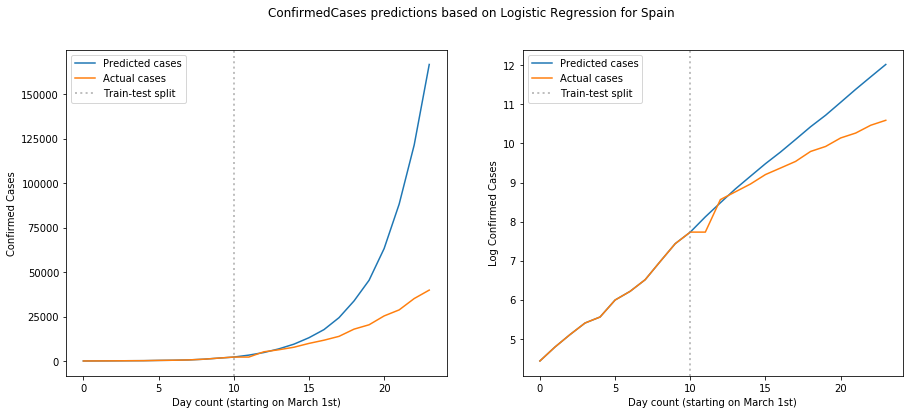

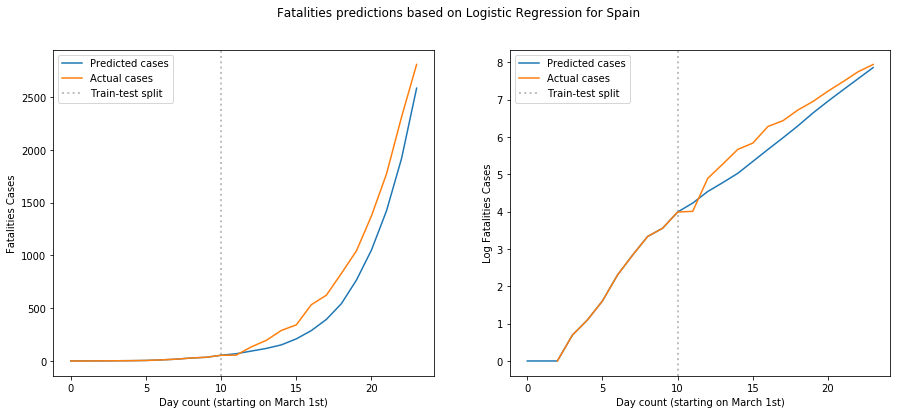

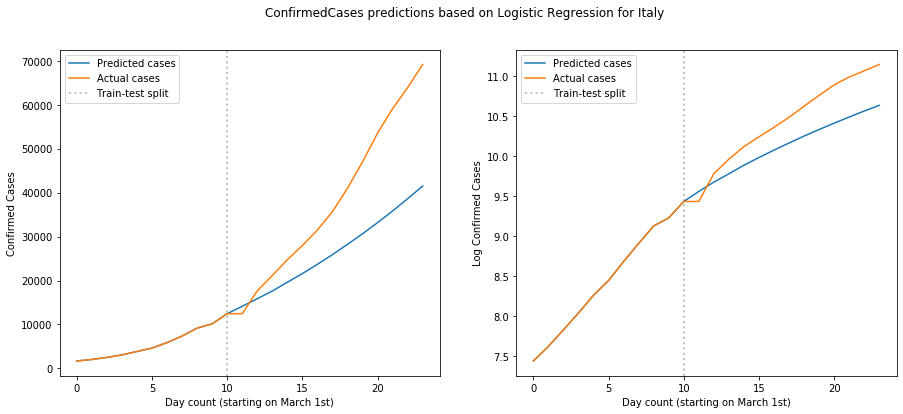

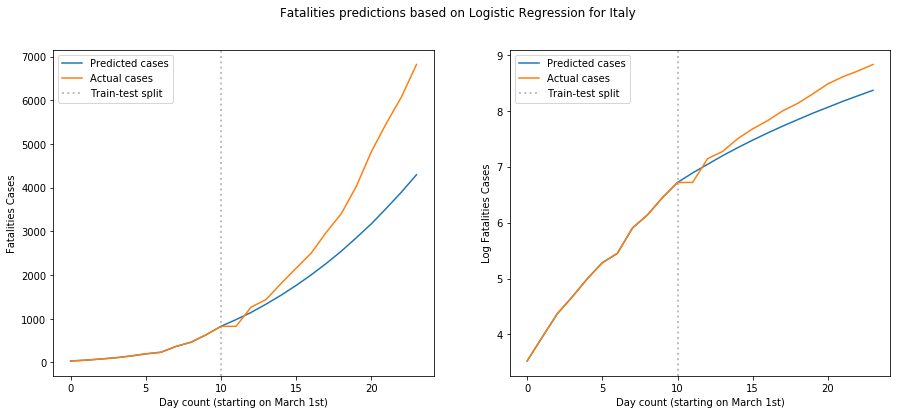

In [14]:
# Run the model for Spain
country_name = 'Spain'
day_start = 35 
lag_size = 30

data = lin_reg_with_lags_country(all_data, country_name, day_start, lag_size, country_dict)
plot_real_vs_prediction_country(data, train, country_name, 39, dates_list)
plot_real_vs_prediction_country_fatalities(data, train, country_name, 39, dates_list)

ts = time.time()

# Inputs
country_name = "Italy"
day_start = 35 
lag_size = 30

data = lin_reg_with_lags_country(all_data, country_name, day_start, lag_size, country_dict)
plot_real_vs_prediction_country(data, train, country_name, 39, dates_list)
plot_real_vs_prediction_country_fatalities(data, train, country_name, 39, dates_list)

**Observations**:
* **Parameters**. Two full weeks of training used (from February 26th to March 11th), with their previous 30 lags
* **Enough data**. (Spain, Italy, Germany). For countries with several ConfirmedCases!=0 in the train dataset (prior to March 11th), predictions are very precise and similar to actual confirmed data
* **Poor data**. (Algeria). Countries with a small number of datapoints in the train dataset show a potentially disastrous prediction. Given the small number of cases, the log transformation followed by a Linear Regression is not able to capture the future behavior
* **No data**. (Andorra). When there are no confirmed cases in the train dataset, the model predicts always 0 infections
* **Fatalities**. As we clarified in [section 4.1](#section41)., filling negative infinities by 0 impacts the inverse transformation of the logarithm. Values that should be 0 are now 1 ($e^0$), and that's the reason of the "weird" (see Andorra) plots for countries that have no fatalities in the training dataset

# Forecasting using Random Forest

In [15]:

from sklearn.model_selection import train_test_split

test_df = pd.read_csv("../input/test.csv")
train_df = pd.read_csv("../input/train.csv")
submission_df = pd.read_csv("../input/submission.csv")
train_df["Date"] = train_df["Date"].apply(lambda x: str(x).replace("-",""))
train_df["Date"]  = train_df["Date"].astype(int)

In [16]:
#drop Province column and all not available entries
train_df = train_df.drop(['Province/State'],axis=1)
train_df = train_df.dropna()
train_df.isnull().sum()
train_df.head(10)

,Id,Country/Region,Lat,Long,Date,ConfirmedCases,Fatalities
0,1,Afghanistan,33.0,65.0,20200122,0.0,0.0
1,2,Afghanistan,33.0,65.0,20200123,0.0,0.0
2,3,Afghanistan,33.0,65.0,20200124,0.0,0.0
3,4,Afghanistan,33.0,65.0,20200125,0.0,0.0
4,5,Afghanistan,33.0,65.0,20200126,0.0,0.0
5,6,Afghanistan,33.0,65.0,20200127,0.0,0.0
6,7,Afghanistan,33.0,65.0,20200128,0.0,0.0
7,8,Afghanistan,33.0,65.0,20200129,0.0,0.0
8,9,Afghanistan,33.0,65.0,20200130,0.0,0.0
9,10,Afghanistan,33.0,65.0,20200131,0.0,0.0


In [17]:
test_df["Date"] = test_df["Date"].apply(lambda x: x.replace("-",""))
test_df["Date"]  = test_df["Date"].astype(int)

test_df["Lat"]  = test_df["Lat"].fillna(12.5211)
test_df["Long"]  = test_df["Long"].fillna(69.9683)
test_df.isnull().sum()
test_df.head(10)

,ForecastId,Province/State,Country/Region,Lat,Long,Date
0,1,NaN,Afghanistan,33.0,65.0,20200312
1,2,NaN,Afghanistan,33.0,65.0,20200313
2,3,NaN,Afghanistan,33.0,65.0,20200314
3,4,NaN,Afghanistan,33.0,65.0,20200315
4,5,NaN,Afghanistan,33.0,65.0,20200316
5,6,NaN,Afghanistan,33.0,65.0,20200317
6,7,NaN,Afghanistan,33.0,65.0,20200318
7,8,NaN,Afghanistan,33.0,65.0,20200319
8,9,NaN,Afghanistan,33.0,65.0,20200320
9,10,NaN,Afghanistan,33.0,65.0,20200321


In [18]:
#Asign columns for training and testing



x = train_df[['Lat', 'Long', 'Date']]
y1 = train_df[['ConfirmedCases']]
y2 = train_df[['Fatalities']]
x_test = test_df[['Lat', 'Long', 'Date']]


In [19]:

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor

model = RandomForestClassifier(n_estimators = 200)

##
model.fit(x,y1)
pred1 = model.predict(x_test)
pred1 = pd.DataFrame(pred1)
pred1.columns = ["ConfirmedCases_prediction"]




In [20]:
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                      max_depth=None, max_features='auto', max_leaf_nodes=None, 
                      n_estimators=150, random_state=None, n_jobs=1, verbose=0)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=150, n_jobs=1,
                       oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [22]:
pred1.head(10)

,ConfirmedCases_prediction
0,7.0
1,7.0
2,11.0
3,22.0
4,22.0
5,22.0
6,22.0
7,24.0
8,24.0
9,24.0


In [23]:
##
model.fit(x,y2)
pred2 = model.predict(x_test)
pred2 = pd.DataFrame(pred2)
pred2.columns = ["Death_prediction"]


In [24]:
pred2.head()

,Death_prediction
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0


In [25]:
test_df["ConfirmedCases"] = pred1["ConfirmedCases_prediction"]
test_df["Death"] = pred2["Death_prediction"]
test_df.head()

,ForecastId,Province/State,Country/Region,Lat,Long,Date,ConfirmedCases,Death
0,1,NaN,Afghanistan,33.0,65.0,20200312,7.0,0.0
1,2,NaN,Afghanistan,33.0,65.0,20200313,7.0,0.0
2,3,NaN,Afghanistan,33.0,65.0,20200314,11.0,0.0
3,4,NaN,Afghanistan,33.0,65.0,20200315,22.0,0.0
4,5,NaN,Afghanistan,33.0,65.0,20200316,22.0,0.0


Text(0.5, 1.0, 'Spread of Corona Virus in China')

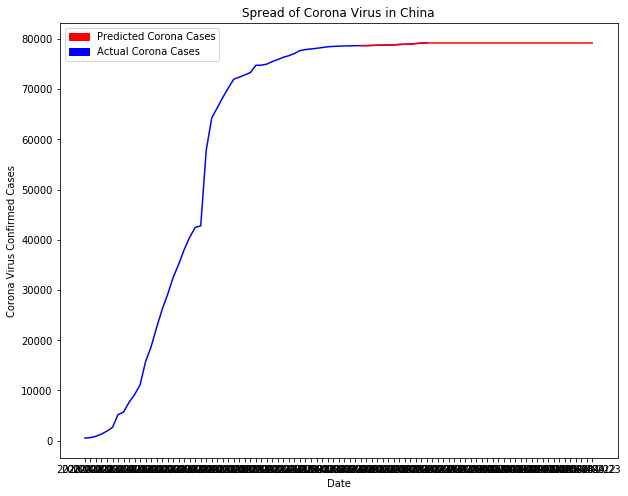

In [26]:
temp1 = pd.read_csv("../input/train.csv")
temp2 = pd.read_csv("../input/test.csv")

train = train_df.loc[(train_df["Country/Region"]=="China")].groupby(["Date"])["ConfirmedCases"].sum().reset_index()
test  = test_df.loc[(test_df["Country/Region"]=="China")].groupby(["Date"])["ConfirmedCases"].sum().reset_index()
train["Date"] = temp1["Date"]
test["Date"] = temp2["Date"]

import matplotlib.patches as mpatches
plt.figure(figsize=(10, 8))
plt.plot(train['Date'], train['ConfirmedCases'], 'b-')
plt.plot(test['Date'], test['ConfirmedCases'], 'r-')
red_patch = mpatches.Patch(color='red', label='Predicted Corona Cases')
blue_patch = mpatches.Patch(color='blue', label='Actual Corona Cases')
plt.legend(handles=[red_patch, blue_patch])
plt.xlabel('Date'); 
plt.ylabel('Corona Virus Confirmed Cases')
plt.title('Spread of Corona Virus in China')

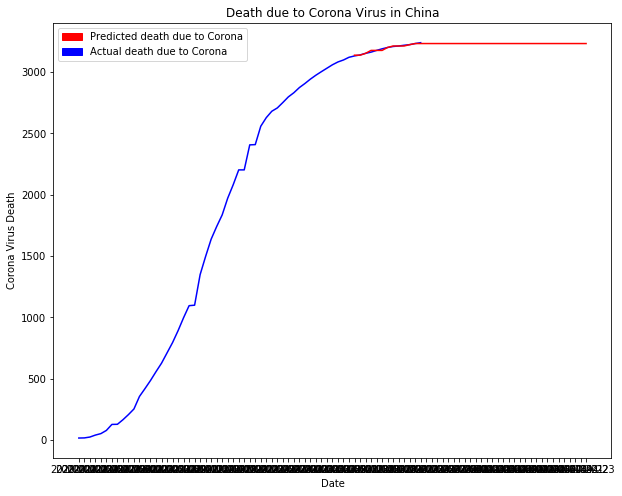

In [27]:
temp1 = pd.read_csv("../input/train.csv")  
temp2 = pd.read_csv("../input/test.csv")
train = train_df.loc[(train_df["Country/Region"]=="China")].groupby(["Date"])["Fatalities"].sum().reset_index()
test  = test_df.loc[(test_df["Country/Region"]=="China")].groupby(["Date"])["Death"].sum().reset_index()
train["Date"] = temp1["Date"]
test["Date"] = temp2["Date"]

import matplotlib.patches as mpatches
plt.figure(figsize=(10, 8))
plt.plot(train['Date'], train['Fatalities'], 'b-')
plt.plot(test['Date'], test['Death'], 'r-')
red_patch = mpatches.Patch(color='red', label='Predicted death due to Corona')
blue_patch = mpatches.Patch(color='blue', label='Actual death due to Corona')
plt.legend(handles=[red_patch, blue_patch])
plt.xlabel('Date'); 
plt.ylabel('Corona Virus Death')
plt.title('Death due to Corona Virus in China');

In [28]:
Sub = pd.read_csv("../input/submission.csv")
sub_new = Sub[["ForecastId"]]
sub_new

,ForecastId
0,1
1,2
2,3
3,4
4,5
...,...
12207,12208
12208,12209
12209,12210
12210,12211


In [29]:
submit = pd.concat([pred1,pred2,sub_new],axis=1)
submit.head()

,ConfirmedCases_prediction,Death_prediction,ForecastId
0,7.0,0.0,1
1,7.0,0.0,2
2,11.0,0.0,3
3,22.0,0.0,4
4,22.0,0.0,5


In [30]:
# Clean
submit.columns = ['ConfirmedCases', 'Fatalities', 'ForecastId']
submit = submit[['ForecastId','ConfirmedCases', 'Fatalities']]

submit["ConfirmedCases"] = submit["ConfirmedCases"].astype(int)
submit["Fatalities"] = submit["Fatalities"].astype(int)

In [31]:
submit.describe()

,ForecastId,ConfirmedCases,Fatalities
count,12212.000000,12212.000000,12212.000000
mean,6106.500000,1161.891336,49.232558
std,3525.445078,6246.070461,406.167987
min,1.000000,0.000000,0.000000
25%,3053.750000,7.000000,0.000000
50%,6106.500000,83.000000,0.000000
75%,9159.250000,353.000000,3.000000
max,12212.000000,69176.000000,6077.000000


In [32]:



x_train_case, x_test_case, y_train_case, y_test_case = train_test_split(train_df[['Lat', 'Long', 'Date']], train_df[['ConfirmedCases']], random_state=1, train_size=0.7)

x_train_fat, x_test_fat, y_train_fat, y_test_fat = train_test_split(train_df[['Lat', 'Long', 'Date']], train_df[['Fatalities']], random_state=1, train_size=0.7)


from sklearn.model_selection import cross_val_score


# random forest 
clf = RandomForestClassifier(n_estimators = 200)
 
# training model 
s_case = clf.fit(x_train_case , y_train_case)

s_fat = clf.fit(x_train_fat , y_train_fat)


r_con = clf.score(x_test_case, y_test_case)
r_fat = clf.score(x_test_fat, y_test_fat)

print("accuracy of confirmedcases %s"%r_con)
print("accuracy of fatalities  %s"%r_fat)

accuracy of confirmedcases 0.6108420268256334
accuracy of fatalities  0.9295827123695977
